# Tesseract Evaluation - zeilenbasiert - psm 1

Per Default ist der Modus --psm 3 bei Tessercat voreingestellt.   
Dieser Modus ist vor allem für beschriebene Seiten geeignet, also gut für das Einlesen von Dokumenten.   
In diesem notebook wird untersucht, ob die Ergebnisse sich bei Verwendung eines anderen Modus verbessern.  
Es wird **--psm 1** benutzt - laut Tesseract "Automatic page segmentation with OSD" (OSD = Orientation and Script Detection)

#### 1. Textextraktion
    1.1 auf einem Beipielbild   
    1.2 auf dem gesamten Datensatz

#### 2. Evaluation
    2.1 Berechnung Char Accuracy und Word Accuracy
    2.2 Berechnung CER
    2.3 Berechnung WER

#### 3. weitere Analysen
    3.1 Erkennungsrate berechnen
    3.2 Char Accuracy und Word Accuraccy je Bildkategorie
    3.3 CER und WER je Bildkategorie
    3.4 Erkennungsrate je Bildkatgeorie

---

### 1. Textextraktion
---

#### 1.1.1 Textextraktion auf einem einzelnen Bild 

In [1]:
# psm 1

import pytesseract
from PIL import Image


img = Image.open("../../data/images/insta_images/0040.jpeg")

text = pytesseract.image_to_string(img, lang=('deu'),config="--psm 1")  

print(text)

SOLI-FESTIVAL

1. März 2025‚

UNSERE
SOLL MAN
HÖREN/

r
{ %
W A

e




In [2]:
# psm 3
import pytesseract
from PIL import Image


img = Image.open("../../data/images/insta_images/0040.jpeg")

text = pytesseract.image_to_string(img, lang=('deu'))  # 'deu' für Deutsch

print(text)

SOLI-FESTIVAL

1. März 2025‚

UNSERE
SOLL MAN
HÖREN/

r
{ %
W A

e




In [61]:
import pytesseract
from PIL import Image
import pandas as pd

# Bild laden
image = Image.open("../../data/images/insta_images/0040.jpeg")

# OCR mit Datenstruktur
ocr_data = pytesseract.image_to_data(image, lang=('deu'), config="--psm 1", output_type=pytesseract.Output.DATAFRAME)
#ocr_data = pytesseract.image_to_data(image, lang=('deu+eng'), output_type=pytesseract.Output.DATAFRAME)

# Nur relevante Spalten und nur nicht-leere Zeilen
ocr_data = ocr_data[ocr_data.conf != -1]  # -1 = kein Text erkannt
ocr_data = ocr_data.dropna(subset=["text"])

# Gruppiere nach block_num, par_num, line_num
grouped = ocr_data.groupby(['block_num', 'par_num', 'line_num'])

# Zeilen zusammensetzen
lines = []
for (_, _, _), group in grouped:
    line_text = ' '.join(group['text'].tolist())
    lines.append(line_text)

# Ausgabe
for i, line in enumerate(lines, 1):
    print(f"Zeile {i}: {line}")

Zeile 1:  
Zeile 2: SOLI-FESTIVAL
Zeile 3: 1. März 2025‚
Zeile 4: UNSERE
Zeile 5: SOLL MAN
Zeile 6: HÖREN/
Zeile 7: r
Zeile 8: { %
Zeile 9: W A
Zeile 10:    
Zeile 11:  
Zeile 12: e
Zeile 13:  


#### 1.1.2 Textextraktion mit zeilenweisem Matching

In [7]:
import os
import json
import pandas as pd

import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines_psm1, cer_for_matching, match_gt_to_ocr, CER_THRESHOLD

# === Konfiguration ===
IMG_NAME = "0020.jpg"              
DIR_PATH = "../../data/images/insta_images"
JSON = "../../data/data_annotated.json"



with open(JSON, "r", encoding="utf-8") as f:
    all_data = json.load(f)

eintrag = next((item for item in all_data if item.get("file_name") == IMG_NAME), None)
if eintrag is None:
    print(f"Kein Groundtruth-Eintrag für {IMG_NAME}")
else:
    gt_lines = eintrag["lines"]
    img_path = os.path.join(DIR_PATH, IMG_NAME)

    if not os.path.exists(img_path):
        print(f"Bild nicht gefunden: {img_path}")
    else:
        ocr_lines = extract_ocr_lines_psm1(img_path)
        matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

        ergebnisse = []
        for gt_idx, ocr_idx in matches:
            gt_line = gt_lines[gt_idx]
            if ocr_idx is not None:
                ocr_line = ocr_lines[ocr_idx]
            else:
                ocr_line = "[Nicht erkannt]"

            ergebnisse.append({
                "GT-Zeile (Index)": gt_idx,
                "GT-Zeile": gt_line,
                "OCR-Zeile (Index)": ocr_idx,
                "OCR-Zeile": ocr_line,
            })

        df = pd.DataFrame(ergebnisse)
        display(df)


,GT-Zeile (Index),GT-Zeile,OCR-Zeile (Index),OCR-Zeile
0,0,DEMONSTRATION,0.0,DEMONSTRATION
1,1,SONNTAG 06.09.2020,1.0,SONNTAG 0F@19.2020;
2,2,SCHÜLER/-INNEN GEGEN DIE MASKENPFLICHT!,NaN,[Nicht erkannt]
3,3,WANN: 15:30 UHR,6.0,WANN: 15:30 UHR
4,4,WO: MEISTERSINGERHALLE NÜRNBERG.,7.0,WO: MEISTERSINGERHALLE
5,5,TOLLE REDNER,NaN,[Nicht erkannt]
6,6,MODERATOR,11.0,MODERATOR
7,7,(NANA LIFESTYLER),12.0,(NANA LIFESTYLER)
8,8,GUNNAR KAISER,NaN,[Nicht erkannt]
9,9,U.V.M.,NaN,[Nicht erkannt]


In [3]:
import Levenshtein

def character_accuracy(ocr_text, ground_truth):
    ocr_text = ocr_text.strip()
    ground_truth = ground_truth.strip()
    max_len = len(ground_truth)
    
    if ocr_text == "[Nicht erkannt]":
        return 0.0
    
    if max_len == 0:
        return 1.0 if not ocr_text else 0.0

    distance = Levenshtein.distance(ocr_text, ground_truth)
    return 1 - (distance / max_len)


df["char_accuracy"] = df.apply(
    lambda row: character_accuracy(row["OCR-Zeile"], row["GT-Zeile"]),
    axis=1
)


In [4]:
df.head(7)

,GT-Zeile (Index),GT-Zeile,OCR-Zeile (Index),OCR-Zeile,char_accuracy
0,0,SCHLIESST EUCH AN!,NaN,[Nicht erkannt],0.0
1,1,ET Video & Content,NaN,[Nicht erkannt],0.0
2,2,nichtohneuns_Dresden,NaN,[Nicht erkannt],0.0
3,3,KUNDGEBUNG,NaN,[Nicht erkannt],0.0
4,4,#SOLIDARITÄT MIT ALLEN!,0.0,#SOLIDARITÄT MIT ALLEN!,1.0
5,5,BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?,1.0,BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?,1.0
6,6,"Dresden, Großer Garten, 8.8. um 16 Uhr",2.0,"Dresden, Großer Garten, 8.8. um 16 Uhr",1.0


In [5]:
mean_acc = df["char_accuracy"].mean()
print((mean_acc)* 100)

42.857142857142854


#### 1.2 Textextraktion auf gesamten Datensatz - zeilenweise Ausgabe (Zeilen gematcht)

In [11]:
import os
import json
import pandas as pd


import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines_psm1, cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD 


# === Konfiguration ===
IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"




with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines_psm1(img_path)
    matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = 0
    cer_list, wer_list, char_acc_list, word_acc_list = [], [], [], []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = ocr_lines[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            cer_list.append(cer_score)
            wer_list.append(wer_score)
            char_acc_list.append(char_acc)
            word_acc_list.append(word_acc)
            total_matches += 1
        else:
            cer_list.append(1.0)
            wer_list.append(1.0)
            char_acc_list.append(0.0)
            word_acc_list.append(0.0)

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(cer_list) / total_gt if total_gt else None,
        "mean_wer": sum(wer_list) / total_gt if total_gt else None,
        "mean_char_acc": sum(char_acc_list) / total_gt if total_gt else None,
        "mean_word_acc": sum(word_acc_list) / total_gt if total_gt else None,
        "ocr_tesseract_psm1": ocr_lines
    })

df_results = pd.DataFrame(ergebnisse)
display(df_results)


,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_tesseract_psm1
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667,"[ , , ÄCHCAFE—&, aHTSFELER, DIENSTAG 21.12..."
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571,"[#SOLIDARITÄT MIT ALLEN!, BERICHTE: WIE WAR DI..."
2,0003.jpg,11,16,5,0.589539,0.621212,0.414100,0.272727,"[Gedenkkundgebung und, antifaschistische Demon..."
3,0004.jpg,11,5,1,0.943574,1.000000,0.059441,0.000000,"[ , Ö, A JEDEIR IST o-LS%WILLKQMMENLÄ, S, ]"
4,0006.jpg,8,4,2,0.790000,0.791667,0.206250,0.125000,"[Aul, DEMO GEGEN GENTRIFIZIERUNG, Na 2022 / 15..."
...,...,...,...,...,...,...,...,...,...
195,0238.jpg,13,16,4,0.775403,0.994872,0.231068,0.000000,"[ , , , BLEIRERECHTSKAMPF, D END, Ar ..."
196,0239.jpg,11,1,0,1.000000,1.000000,0.000000,0.000000,[ ]
197,0240.jpg,10,10,10,0.014345,0.116667,0.995833,0.816667,"[#KeinFussbreit!, Antisemitismus und, Rassismu..."
198,0241.jpg,17,38,1,0.942455,0.952941,0.057423,0.047059,"[ , , , , , , , , , , , , DEMOKRATI..."


In [12]:
df_results.to_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm1.csv", index=False)

---
### 2. Evaluation
---

#### 2.1 Berechnung Character Accuracy und Word Accuracy


In [15]:
char_acc_mean_all = df_results["mean_char_acc"].mean()
print(f"Durchschnittliche Character Accuracy mit psm 1: {char_acc_mean_all * 100:.2f}%")

Durchschnittliche Character Accuracy mit psm 1: 38.85%


Durchschnittliche Character Accuracy : 39.02%  mit psm 3

In [16]:
word_acc_mean_all = df_results["mean_word_acc"].mean()
print(f"Durchschnittliche Word Accuracy mit psm 1: {word_acc_mean_all * 100:.2f}%")

Durchschnittliche Word Accuracy mit psm 1: 29.46%


Durchschnittliche Word Accuracy : 29.57% mit psm 3

#### 2.2.1 Berechnung CER (Character Error Rate)

In [17]:
cer_mean_all = df_results["mean_cer"].mean()
print(f"Durchschnittlicher CER mit psm 1: {cer_mean_all * 100:.2f}%")

Durchschnittlicher CER mit psm 1: 61.81%


Durchschnittlicher CER : 61.65% bei psm3

#### 2.2.2 Berechnung WER (Word Error Rate)

In [18]:
wer_mean_all = df_results["mean_wer"].mean()
print(f"Durchschnittlicher WER mit psm 1: {wer_mean_all * 100:.2f}%")

Durchschnittlicher WER mit psm 1: 71.76%


Durchschnittlicher WER : 71.68% mit psm 3

##### ---> keine Verbesserung gegenüber psm3



In [19]:
df_results.to_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm1.csv", index=False)

#### Prüfung, ob Werte bei normalisiertem Text differieren

In [30]:
import os
import json
import pandas as pd


import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines_psm1, cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD 


# === Konfiguration ===
IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"


# === Hilfsfunktion ===
def normalize_text(ocr_tesseract):
    return ' '.join(str(ocr_tesseract).split()) if pd.notna(ocr_tesseract) else ''


with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines_psm1(img_path)
    normalized_lines = [normalize_text(line) for line in ocr_lines]
    matches = match_gt_to_ocr(gt_lines, normalized_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = 0
    cer_list, wer_list, char_acc_list, word_acc_list = [], [], [], []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = normalized_lines[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            cer_list.append(cer_score)
            wer_list.append(wer_score)
            char_acc_list.append(char_acc)
            word_acc_list.append(word_acc)
            total_matches += 1
        else:
            cer_list.append(1.0)
            wer_list.append(1.0)
            char_acc_list.append(0.0)
            word_acc_list.append(0.0)

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(cer_list) / total_gt if total_gt else None,
        "mean_wer": sum(wer_list) / total_gt if total_gt else None,
        "mean_char_acc": sum(char_acc_list) / total_gt if total_gt else None,
        "mean_word_acc": sum(word_acc_list) / total_gt if total_gt else None
    })

df_results_normalized = pd.DataFrame(ergebnisse)
display(df_results_normalized)


,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571
2,0003.jpg,11,16,5,0.589539,0.621212,0.414100,0.272727
3,0004.jpg,11,5,1,0.943574,1.000000,0.059441,0.000000
4,0006.jpg,8,4,2,0.790000,0.791667,0.206250,0.125000
...,...,...,...,...,...,...,...,...
195,0238.jpg,13,16,4,0.775403,0.994872,0.231068,0.000000
196,0239.jpg,11,1,0,1.000000,1.000000,0.000000,0.000000
197,0240.jpg,10,10,10,0.014345,0.116667,0.995833,0.816667
198,0241.jpg,17,38,1,0.942455,0.952941,0.057423,0.047059


In [31]:
char_acc_mean_all = df_results_normalized["mean_char_acc"].mean()
print(f"Durchschnittliche Character Accuracy : {char_acc_mean_all * 100:.2f}%")

Durchschnittliche Character Accuracy : 38.85%


In [32]:
word_acc_mean_all = df_results_normalized["mean_word_acc"].mean()
print(f"Durchschnittliche Word Accuracy : {word_acc_mean_all * 100:.2f}%")

Durchschnittliche Word Accuracy : 29.46%


In [33]:
cer_mean_all = df_results_normalized["mean_cer"].mean()
print(f"Durchschnittlicher CER : {cer_mean_all * 100:.2f}%")

Durchschnittlicher CER : 61.81%


In [34]:
wer_mean_all = df_results_normalized["mean_wer"].mean()
print(f"Durchschnittlicher WER : {wer_mean_all * 100:.2f}%")

Durchschnittlicher WER : 71.76%


----> die Werte des normalisierten Textes unterscheiden sich nicht von dem nicht nachträglich bearbeiteten Text.   
Der Text war schon zuvor frei von unnötigen Leerzeichen oder Tabs. Die Ergebnisse/Werte des normailisierten Textes werden deshalb nicht eigens gespeichert.


---
### 3. weitere Analysen
---

#### joinen der beiden Datensätze  (CSV mit ground truth und generierte Evaluationsdatei) 


In [35]:
import pandas as pd

df_pics = pd.read_csv("../../data/image_data_with_groundtruth.csv")
df = pd.read_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm1.csv")


In [36]:
# Nur die Spalten "name" und "category" 
df_pics_little = df_pics[["file_name", "category"]]

# Merge 
merged_df = df.merge(df_pics_little, on="file_name", how="left")


merged_df.head()


,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_tesseract_psm1,category
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667,"[' ', ' ', 'ÄCHCAFE—&', 'aHTSFELER', 'DIENS...",noisy
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571,"['#SOLIDARITÄT MIT ALLEN!', 'BERICHTE: WIE WAR...",noisy
2,0003.jpg,11,16,5,0.589539,0.621212,0.414100,0.272727,"['Gedenkkundgebung und', 'antifaschistische De...",noisy
3,0004.jpg,11,5,1,0.943574,1.000000,0.059441,0.000000,"[' ', 'Ö', 'A JEDEIR IST o-LS%WILLKQMMENLÄ', '...",noisy
4,0006.jpg,8,4,2,0.790000,0.791667,0.206250,0.125000,"['Aul', 'DEMO GEGEN GENTRIFIZIERUNG', 'Na 2022...",noisy


In [37]:
matched_lines_mean = merged_df["matched_lines"].mean()
print(matched_lines_mean)


4.26


In [38]:
gt_lines_mean = merged_df["gt_lines"].mean()
print(gt_lines_mean)

10.22


In [39]:
matched_lines_mean_per_cat = merged_df.groupby("category")["matched_lines"].mean() 
print(matched_lines_mean_per_cat)

category
fancy     3.981481
noisy     2.866667
photo     3.800000
simple    5.230769
skewed    4.354839
Name: matched_lines, dtype: float64


---
#### 3.1 Erkennungsrate berrechnen
Wie viele Zeilen des Ground Truth wurden je Bild erkannt?

In [40]:
merged_df["recognition_rate"] = merged_df["matched_lines"] / merged_df["gt_lines"]


In [41]:
merged_df.head(2)

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_tesseract_psm1,category,recognition_rate
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667,"[' ', ' ', 'ÄCHCAFE—&', 'aHTSFELER', 'DIENS...",noisy,0.666667
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571,"['#SOLIDARITÄT MIT ALLEN!', 'BERICHTE: WIE WAR...",noisy,0.428571


In [42]:
merged_df.to_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm1.csv", index=False)

In [43]:
# Durchschnitt berechnen
mean_cer = merged_df["mean_cer"].mean()
mean_wer = merged_df["mean_wer"].mean()
mean_ER = merged_df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")


Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.418
CER: 0.618
WER: 0.718


Werte bei psm 3:

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.420
CER: 0.617
WER: 0.717

---
#### 3.2 Char Accuracy und Word Accuracy je Bildkategorie

In [44]:
CHAR_ACC_by_category = merged_df.groupby("category")["mean_char_acc"].mean() * 100
CHAR_ACC_by_category = CHAR_ACC_by_category.round(2)
CHAR_ACC_by_category = CHAR_ACC_by_category.sort_values(ascending=False)

print(CHAR_ACC_by_category)

category
simple    52.42
skewed    36.74
fancy     32.64
noisy     29.28
photo     29.15
Name: mean_char_acc, dtype: float64


In [45]:
WORD_ACC_by_category = merged_df.groupby("category")["mean_word_acc"].mean() * 100
WORD_ACC_by_category = WORD_ACC_by_category.round(2)
WORD_ACC_by_category = WORD_ACC_by_category.sort_values(ascending=False)

print(WORD_ACC_by_category)

category
simple    43.89
skewed    28.03
fancy     21.61
noisy     20.35
photo     19.62
Name: mean_word_acc, dtype: float64


---
#### 3.3 CER und WER je Bildkategorie

In [46]:
CER_by_category = merged_df.groupby("category")["mean_cer"].mean() * 100
CER_by_category = CER_by_category.round(2)
CER_by_category = CER_by_category.sort_values(ascending=True)

print(CER_by_category)

category
simple    48.24
skewed    63.95
fancy     68.07
noisy     71.17
photo     71.66
Name: mean_cer, dtype: float64


In [47]:
WER_by_category = merged_df.groupby("category")["mean_wer"].mean() * 100
WER_by_category = WER_by_category.round(2)
WER_by_category = WER_by_category.sort_values(ascending=True)
print(WER_by_category)

category
simple    56.46
skewed    74.39
noisy     80.43
photo     80.45
fancy     80.63
Name: mean_wer, dtype: float64


---
#### 3.3 Erkennungsrate je Bildkategorie

In [48]:
Erkennungsrate_by_category = merged_df.groupby("category")["recognition_rate"].mean() * 100
Erkennungsrate_by_category = Erkennungsrate_by_category.round(2)
Erkennungsrate_by_category = Erkennungsrate_by_category.sort_values(ascending=False)

print(Erkennungsrate_by_category)

category
simple    55.23
skewed    39.76
fancy     35.76
photo     32.47
noisy     31.93
Name: recognition_rate, dtype: float64


---

In [52]:
import pandas as pd

df = pd.read_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm1.csv")

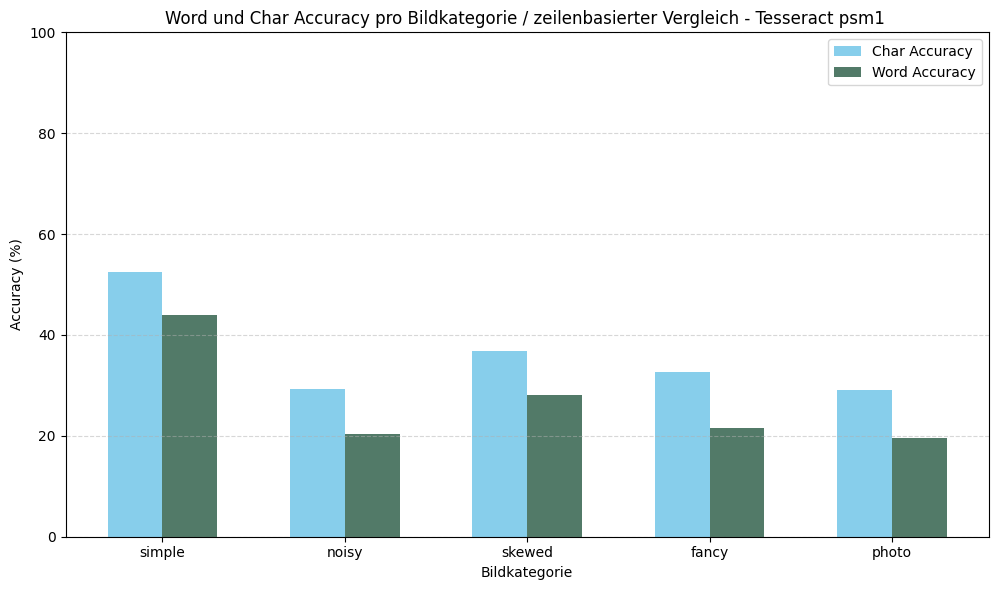

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
word_accuracy = [43.89, 20.35, 28.03, 21.61, 19.62]
char_accuracy = [52.42, 29.28, 36.74, 32.64, 29.15]



df = pd.DataFrame({
    'category': categories,
    'word_accuracy': word_accuracy,
    'char_accuracy': char_accuracy
})

# Balkendiagramm
x = range(len(categories))
bar_width = 0.30

plt.figure(figsize=(10, 6))
plt.bar(x, df['char_accuracy'], width=bar_width, label='Char Accuracy', color='skyblue')
plt.bar([i + bar_width for i in x], df['word_accuracy'], width=bar_width, label='Word Accuracy', color='#527a68')

plt.xlabel('Bildkategorie')
plt.ylabel('Accuracy (%)')
plt.title('Word und Char Accuracy pro Bildkategorie / zeilenbasierter Vergleich - Tesseract psm1 ')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.show()

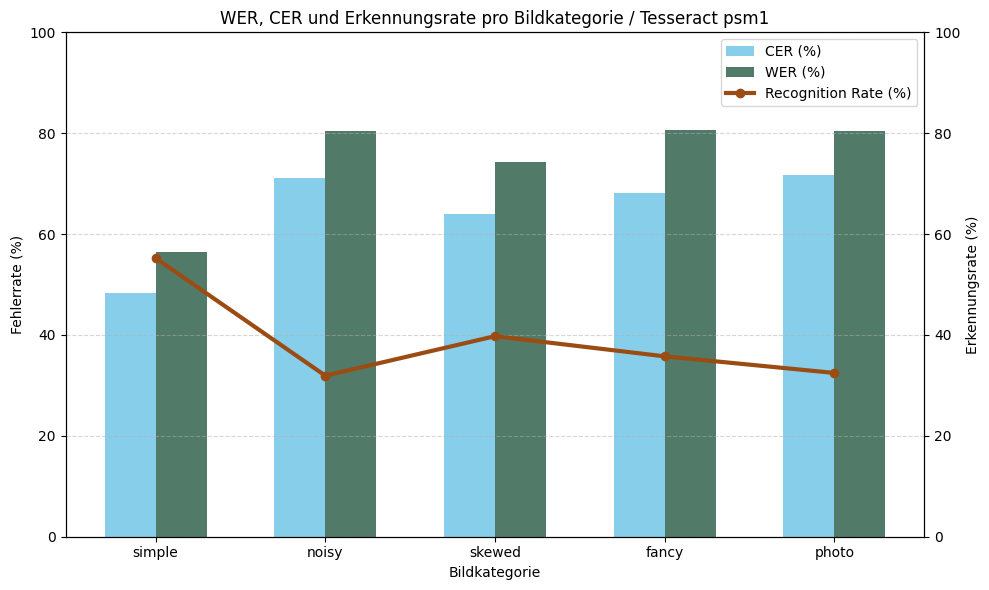

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Gruppierte Mittelwerte berechnen (automatisch!)
grouped = merged_df.groupby("category").agg({
    "mean_wer": "mean",
    "mean_cer": "mean",
    "recognition_rate": "mean"
}) * 100  # Alle Werte als Prozent

# Kategorien extrahieren
#categories = grouped.index.tolist()
categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
grouped = grouped.loc[categories]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(categories))
bar_width = 0.30

# Balken für CER und WER
ax1.bar(x, grouped["mean_cer"], width=bar_width, label='CER (%)', color='skyblue')
ax1.bar([i + bar_width for i in x], grouped["mean_wer"], width=bar_width, label='WER (%)', color='#527a68')

ax1.set_ylabel('Fehlerrate (%)')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Bildkategorie')
ax1.set_xticks([i + bar_width / 2 for i in x])
ax1.set_xticklabels(categories)

# Zweite Y-Achse für Erkennungsrate
ax2 = ax1.twinx()
ax2.plot([i + bar_width / 2 for i in x], grouped["recognition_rate"], label='Recognition Rate (%)',
         color='#9B4C13', marker='o', linewidth=3)
ax2.set_ylabel('Erkennungsrate (%)')
ax2.set_ylim(0, 100)

# Legenden zusammenführen
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('WER, CER und Erkennungsrate pro Bildkategorie / Tesseract psm1')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


---

In [54]:
# images bei denen kein Text extrahiert wurde
merged_df[merged_df['ocr_lines'] == 0].groupby('category').size()

Series([], dtype: int64)

In [55]:
# images bei denen keine Zeile des OCR textes mit dem einer Zeile des ground truth matcht
merged_df[merged_df['matched_lines'] == 0].groupby('category').size()

category
fancy      9
noisy     10
photo      7
simple     7
skewed     7
dtype: int64

In [56]:
# images die eine guten WER haben 
merged_df[merged_df['mean_wer'] < 0.11].groupby('category').size()

category
simple    6
dtype: int64

In [57]:
# images die eine guten CER haben 
merged_df[merged_df['mean_cer'] < 0.05].groupby('category').size()

category
simple    5
dtype: int64